In [1]:
# 🚩 Step:3-1
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

In [2]:
# 🚩 Step:3-2
# 画像の読み込み
img_letter = cv2.imread("data/letter.png")

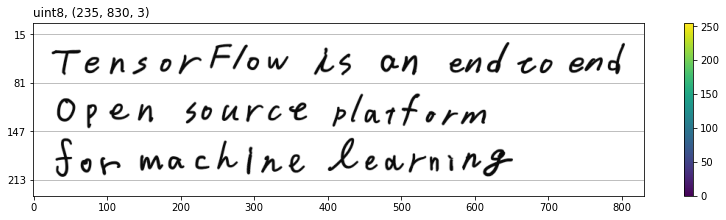

In [3]:
# Matplotlib 3.3.0より前のimshow互換用 (h,w,1)→(h,w)
def compatible_image(img):
    if img.ndim == 3 and img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])
    return img


def show_image(img, y_offset=0, y_steps=None, colorbar=True):
    plt.rcParams["font.size"] = 10
    plt.figure(figsize=(12, 3))
    plt.imshow(compatible_image(img))
    plt.title("{}, {}".format(img.dtype, img.shape), fontsize=12, loc="left")
    if y_steps:
        plt.yticks(np.arange(y_offset, img.shape[0] + 1, y_steps))
        plt.grid(True, axis="y")
    if colorbar:
        plt.colorbar()
    plt.tight_layout()
    plt.show()


# 🚩 Step:3-3
show_image(img_letter, y_offset=15, y_steps=66)

In [4]:
def merge_bboxes(bboxes, threshold, min_size=2, max_size=64):
    """類似するバウンディングボックスをマージする"""
    # 矩形サイズが min/max に収まらない対象を省く（ノイズを省く）
    targets = filter(
        # x[0]=x, x[1]=y, x[2]=w, x[3]=h
        lambda x: min_size <= x[2] <= max_size and min_size <= x[3] <= max_size,
        bboxes,
    )
    # ほぼ同じ矩形（thresholdの範囲内に収まる矩形）を排除
    results = []
    for bbox in targets:
        like_bbox = list(
            filter(
                # x[0]=x, x[1]=y, x[2]=w, x[3]=h
                lambda x: x[0] - threshold <= bbox[0] <= x[0] + threshold
                and x[1] - threshold <= bbox[1] <= x[1] + threshold
                and x[2] - threshold <= bbox[2] <= x[2] + threshold
                and x[3] - threshold <= bbox[3] <= x[3] + threshold,
                results,
            )
        )
        # 類似する矩形が存在しない場合だけ追加
        if like_bbox == []:
            results.append(bbox)

    return results


def detect_bboxes(img, y_offset, y_steps, delta=40, min_area=80, max_area=400):
    """画像から文字領域のバウンディングボックスを検出して返す"""
    # Create MSER
    mser = cv2.MSER_create()
    mser.setDelta(delta)
    mser.setMinArea(min_area)
    mser.setMaxArea(max_area)
    mser.setPass2Only(True)  # MSER +/-片方のみ

    # MSER用に画像を変換
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # 文字部分を抽出
    msers, bboxes = mser.detectRegions(gray)
    unique_bboxes = merge_bboxes(bboxes, threshold=16)  # 類似する範囲をマージ

    # 検出した矩形の順番はバラバラなので左上から右方向の順でソート
    # 今回は簡素化して、各段落が等間隔で並んでいる前提とする
    # 段落番号(0,1,2...) x 横幅 + x座標 の昇順にソート
    img_width = gray.shape[1]
    unique_bboxes.sort(
        key=lambda b: int((b[1] - y_offset) / y_steps) * img_width + b[0]
    )

    return unique_bboxes


# 🚩 Step:3-4
# 各文字の範囲を抽出
bboxes = detect_bboxes(img_letter, y_offset=15, y_steps=66)

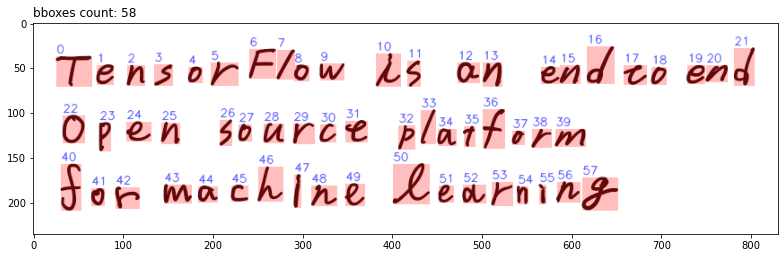

In [5]:
# 検出したバウンディングボックスの確認
def show_bboxes(img, bboxes, alpha=0.25):
    # 領域を描画
    vis, overlay = img.copy(), img.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (0xFF, 0x00, 0), thickness=-1)
        cv2.putText(vis, str(i), (x, y - 4), font, 0.42, (0, 0, 0xFF), 1, cv2.LINE_AA)
    vis = cv2.addWeighted(overlay, alpha + 0.1, vis, 1 - alpha, 0)

    # 表示
    plt.rcParams["font.size"] = 10
    plt.figure(figsize=(11, 4))
    plt.imshow(compatible_image(vis))
    plt.title("bboxes count: {}".format(len(bboxes)), fontsize=12, loc="left")
    plt.tight_layout()
    plt.show()


# 🚩 Step:3-5
show_bboxes(img_letter, bboxes)

In [6]:
def crop_image(img, bbox, target_size, padding, expand=1):
    # 画像の切り出し（expandのサイズだけ枠を拡大）
    x, y, w, h = bbox
    crop = tf.image.crop_to_bounding_box(
        img, y - expand, x - expand, h + (expand * 2), w + (expand * 2)
    )

    # 余白を入れて正方形に成形（長辺に合わせて正方形にする）
    iw, ih, _ = crop.shape
    edge_len = tf.reduce_max([iw, ih]) + (padding * 2)  # 長辺のサイズ
    crop = tf.image.resize_with_crop_or_pad(crop, edge_len, edge_len)

    # 指定サイズにリサイズ（アルゴリズムによっては縮小で白色部分が少なくなるので注意）
    method = tf.image.ResizeMethod.MITCHELLCUBIC
    crop = tf.image.resize(crop, [target_size, target_size], method=method)

    return crop


def setup_data(img, bboxes, target_size=28, padding=2):
    """調整済みの画像を(batch,height,width,ch=1)の4次元形式で返す"""
    # Normalize
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    gray = gray.astype("float32")
    gray = gray / 255.0
    gray = np.expand_dims(gray, 2)  # (h,w)->(h,w,ch=1)形式に変換

    # 28x28のサイズに調整して切り出し
    crop_images = []
    for i, bbox in enumerate(bboxes):
        crop_images.append(crop_image(gray, bbox, target_size, padding))

    # listから(batch,h,w,ch)の4次元形式に変換して返す
    return np.array(crop_images)


# 🚩 Step:3-6
# 各文字を学習で利用した画像と同じような形式で抜き出す
crop_images = setup_data(img_letter, bboxes)

(58, 28, 28, 1)


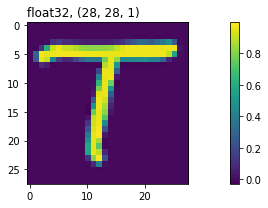

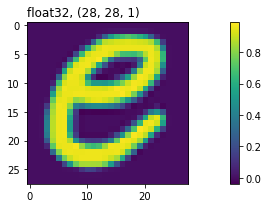

In [7]:
# 🚩 Step:3-7
# 調整済み画像の確認
print(crop_images.shape)
show_image(crop_images[0])
show_image(crop_images[1])

In [8]:
# 🚩 Step:3-8
# 学習済みモデルの読み込み
model = keras.models.load_model("data/emnist-model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        3

TENSORFLOW LS AN END TO END OPEN SOURCE PLATFORM FOR MACHLNE LEARNING
           I                                             I           


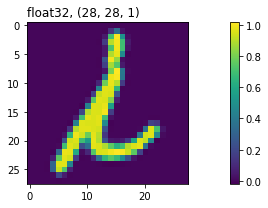

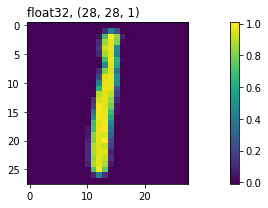

In [9]:
# 🚩 Step:3-9
# 学習済みモデルを使って切り出した画像の予測
predictions = model.predict(crop_images)

# 結果を表示
class_names = list(" ABCDEFGHIJKLMNOPQRSTUVWXYZ")
true_msg = "TENSORFLOWISANENDTOENDOPENSOURCEPLATFORMFORMACHINELEARNING"
split_pos = [9, 11, 13, 16, 18, 21, 25, 31, 39, 42, 49]  # 区切る場所（見やすく表示するため）

pred_msg, corr_msg, errors = [], [], []
for i, pred in enumerate(predictions):
    pred_str = class_names[np.argmax(pred)]
    pred_msg.append(pred_str)

    if pred_str != true_msg[i]:  # 不正解
        corr_msg.append(true_msg[i])
        errors.append(i)
    else:
        corr_msg.append(" ")

    if i in split_pos:
        pred_msg.append(" ")
        corr_msg.append(" ")

print("".join(pred_msg))
print("".join(corr_msg))

for i in errors:
    show_image(crop_images[i])